# Project 4: West Nile Virus Prediction


Our client requested for us to provide suggestions of when and where to spray for mosquitoes which have the West Nile Virus in order to decrease their city's rate of infection and death rate.

**Client:** [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph.html)

**Problem Statement Analysis:** We analyze the severity of the West Nile Virus to find the best metric to best tackle the client's request.
We find that the West Nile Virus is fatal for a small proportion of the population, especially those who are older and have a weaker immune system. For the general population, about [20% of those infected](https://www.cdc.gov/westnile/index.html) will develop a fever. While this may not be fatal, those contracting the fever will have a productivity loss, and tax the city's public health services. With Covid still being prevalent, we believe that we should aim to decrease the number of WNV cases, whether it results in a fatality or a fever. As such, we believe that while our focus should be developing accurate predictions, it is just as important to maximize the number of true findings (sensitivity). 

**Metric Optimized:** ROC-AUC score, Sensitivity / Recall 



## Contents:
- [Background](#Background)
- [Train dataset](#Train-dataset)
- [Test dataset](#Test-set)
- [Spray dataset](#Spray-dataset)
- [Weather dataset](#Weather-dataset)
- [Combined dataset](#Combined-dataset)

## Background
West Nile virus (WNV) (Flaviviridae: Flavivirus) is an arbovirus circulating among mosquitoes, which serve as the vectors, and wild birds, which serve as the main reservoir hosts. WNV raises public health concerns for its ability to infect humans, which are considered dead-end hosts due to our inability to develop a sufficient viremia to infect mosquitoes. So, environmental surveillance, particularly surveillance based on mosquito sampling, can provide early detection of the virus circulation before the onset of the disease in humans.  
<br> WNV typically spreads via the bite of infected mosquitoes. Most mosquitoes do not carry the virus. While most people infected with WNV do not feel sick, about 1 in 5 people develop a fever and flu-like symptoms. Severe illness can occur in about 1 in 150 people and is most likely in people over age 60. Because there are no specific medications to treat WNV in people, the most effective method to prevent infection is to prevent mosquito bites ([source](https://www.chicago.gov/city/en/depts/cdph/provdrs/health_protection_and_response/news/2021/july/cdph-conducts-a-comprehensive-mosquito-surveillance-and-control-.html)).
<br>
<br> So, every year, from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitoes, and the mosquitoes are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitoes, the mosquitoes species, and whether or not West Nile virus is present in the cohort. 



In [1]:
# Import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
pd.options.mode.chained_assignment = None  # default='warn'

from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist


# Data

**Data from [Kaggle](https://www.kaggle.com/c/predict-west-nile-virus/data):** 
* spray.csv: this is the GIS data for the City of Chicago's spray efforts in 2011 and 2013
* weather.csv: this contains weather conditions of 2007 to 2014, during the months of the tests, from NOAA
* train.csv: this is the training dataset
* test.csv: this is the test dataset

## Data Import 


In [2]:
# spray = pd.read_csv('../raw-data/spray.csv')
# weather = pd.read_csv('../raw-data/weather.csv')
# train = pd.read_csv('../raw-data/train.csv')
# test = pd.read_csv('../raw-data/test.csv')

In [3]:
spray = pd.read_csv('../data/spray.csv')
weather = pd.read_csv('../data/weather.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## Maps

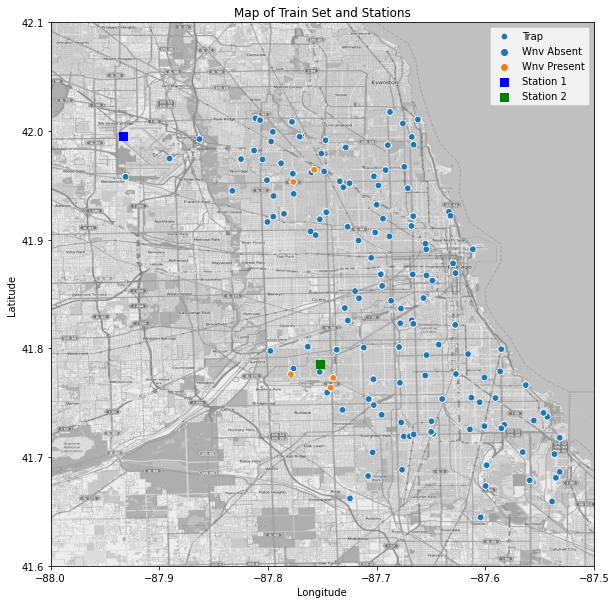

In [4]:
# https://www.kaggle.com/c/predict-west-nile-virus/
# This shows how to read the text representing a map of Chicago in numpy, and put it on a plot in matplotlib.
# This example also rescales the image data to the GPS co-ordinates of the bounding box and overlays some random points.

import numpy as np
import matplotlib.pyplot as plt

origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

# mapdata = np.loadtxt('data/mapdata_copyright_openstreetmap_contributors.txt')
mapdata = np.loadtxt('../data/mapdata_copyright_openstreetmap_contributors.txt')

# generate some data to overlay
numPoints = 300
lats = train['Latitude']
longs = train['Longitude']
wnv = train['WnvPresent']

station_1 = [41.995, -87.933]  # Co-ords of station 1 (Chicago O'Hare Int'l Airport)
station_2 = [41.786, -87.752]  # Co-ords of station 2 (Chicago Midway Int'l Airport)

plt.figure(figsize=(10,10))

# generate plot
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
sns.scatterplot(x=longs, y=lats, 
                c='k', 
                hue=wnv, 
                s=40)

plt.scatter(x=station_1[1], y=station_1[0], c='b', s=60, marker='s')
plt.scatter(x=station_2[1], y=station_2[0], c='g', s=60, marker='s')

# plt.show()
plt.title('Map of Train Set and Stations')
plt.legend(['Trap', 'Wnv Absent', 'Wnv Present', 'Station 1', 'Station 2']);
plt.savefig('map.png')

## Train dataset

In [5]:
#preview training data
train

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,"5100 W 72ND ST, Chicago, IL",41.763733,-87.742302,8,6,1
10502,2013-09-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,5,0
10503,2013-09-26,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.912563,-87.668055,9,1,0
10504,2013-09-26,"7100 North Harlem Avenue, Chicago, IL 60631, USA",CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,"7100 N HARLEM AVE, Chicago, IL",42.009876,-87.807277,9,5,0


In [6]:
train.shape

(10506, 12)

### Preliminary Changes

#### Renamed Column Names to Lowercase


In [7]:
# Renamed column names to lowercase
train.columns = train.columns.str.lower()

In [8]:
train.dtypes

date                       object
address                    object
species                    object
block                       int64
street                     object
trap                       object
addressnumberandstreet     object
latitude                  float64
longitude                 float64
addressaccuracy             int64
nummosquitos                int64
wnvpresent                  int64
dtype: object

#### Change Data Type

We changed the format of ```Column: 'date'``` from ```object``` to ```datetime64[ns]``` to enable the dates to be read appropriately.

In [9]:
# change date to numerical
train['date'] = pd.to_datetime(train['date'])

### Ranking Species

We find that some species has a higher probability of carrying the West Nile Virus than others. In particular, a ```Culex Pipiens``` has a higher probability of carrying the virus as compared to ```Culex Restuans```. Accordingly, we rank their probability of carrying the virus in ordinal values, where a higher value denotes that the species has a higher probability of carrying the virus.

|Species|Probability|Ordinal Value|
|-------|-----------|----|
|Cullex Pipiens|8.89%|3|
|Cullex Pipiens/Restuans|5.51%|2|
|Cullex Restuans|1.79%|1|
|All Others|0.00%|np.nan|

In [10]:
# Number of traps which catches any mosquito.
mozzies_1 = train.loc[train['nummosquitos'] > 0,['species', 'nummosquitos']].groupby('species').count()
mozzies_1.rename(columns={'nummosquitos': 'catches'}, inplace=True)

# Number of traps which catches a wnv mozzie.
mozzies_2 = train[['species', 'nummosquitos', 'wnvpresent']].groupby(by='species').sum()

# Merging the two above.
mozzies_freq = pd.merge(left=mozzies_1,
                        right=mozzies_2,
                        on='species',
                        how='outer'
                       ).fillna(0)

# How often a wnv mozzie is caught in any catch.
mozzies_freq['catch_freq'] = mozzies_freq['wnvpresent'] / mozzies_freq['catches']
mozzies_freq['present_freq'] = mozzies_freq['wnvpresent'] / mozzies_freq['nummosquitos']


# Basically this that it's more likely to find Wnv in pipiens, then pipiens/restuans, then restuans
# I think the species ranking should be:
# 3: Pipiens
# 2: Pipiens/Restuans
# 1: Restuans
# Based on the likelihood a wnv is found in a species-based catch.
mozzies_freq.reset_index(inplace=True)
mozzies_freq

,species,catches,nummosquitos,wnvpresent,catch_freq,present_freq
0,CULEX ERRATICUS,1,7,0,0.000000,0.000000
1,CULEX PIPIENS,2699,44671,240,0.088922,0.005373
2,CULEX PIPIENS/RESTUANS,4752,66268,262,0.055135,0.003954
3,CULEX RESTUANS,2740,23431,49,0.017883,0.002091
4,CULEX SALINARIUS,86,145,0,0.000000,0.000000
5,CULEX TARSALIS,6,7,0,0.000000,0.000000
6,CULEX TERRITANS,222,510,0,0.000000,0.000000


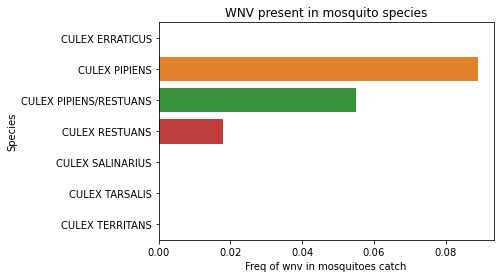

In [11]:
# plot
sns.barplot(data=mozzies_freq, x='catch_freq', y='species');
plt.title('WNV present in mosquito species')
plt.xlabel('Freq of wnv in mosquitoes catch')
plt.ylabel('Species');


From the above plot, the dominant species carrying the west nile virus are the culex pipiens, culex restuans and culex pipiens/restuans. This parameter will be converted to ordinal. The other species will be dropped.

In [12]:
# rank species
# larger value, more likely to have wnvpresent
mspecies = {'CULEX PIPIENS': 3, 'CULEX PIPIENS/RESTUANS': 2, 'CULEX RESTUANS': 1}
train['species_nr'] = train['species'].map(mspecies)

In [13]:
# nan is given for rows of other species
train['species_nr'].unique()

array([ 2.,  1.,  3., nan])

In [14]:
# replace other species with '0'
train['species_nr'] = train['species_nr'].fillna(0)

In [15]:
# drop species column
train.drop(columns=['species'],inplace=True)

### Combine Number of Mosquitos

While nummosquitos are not in the test set, we believe that we can create a feature based on the training data which will provide additional predictive power to our model. We note that the maximum number of mosquitos in a row is 50. However, multiple traps may exist for the same location. As such, we combine the number of mosquitos caught based on the traps.

In [16]:
# check duplicates
train.loc[train.duplicated(subset=['date','trap'])]

,date,address,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,species_nr
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,1.0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,1.0
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0,1.0
12,2007-05-29,"2200 North Cannon Drive, Chicago, IL 60614, USA",22,N CANNON DR,T054,"2200 N CANNON DR, Chicago, IL",41.921965,-87.632085,8,3,0,1.0
14,2007-05-29,"2200 West 113th Street, Chicago, IL 60643, USA",22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10488,2013-09-26,"ORD Terminal 5, O'Hare International Airport, ...",10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,11,0,3.0
10489,2013-09-26,"ORD Terminal 5, O'Hare International Airport, ...",10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,1,0,3.0
10492,2013-09-26,"5100 North Mont Clare Avenue, Chicago, IL 6065...",51,N MONT CLARE AVE,T223,"5100 N MONT CLARE AVE, Chicago, IL",41.973845,-87.805059,9,1,0,3.0
10495,2013-09-26,"East 91st Place, Chicago, IL, USA",65,E 91ST PL,T227,"6500 E 91ST PL, Chicago, IL",41.728495,-87.600963,5,1,0,3.0


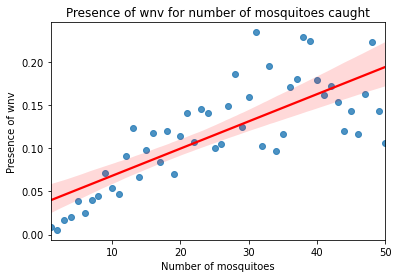

In [17]:
# plot nummosquitos and wnvpresent
sns.regplot(x=train.groupby(['nummosquitos'])['wnvpresent'].mean().index,y=train.groupby(['nummosquitos'])['wnvpresent'].mean(),line_kws={"color": "red"})
plt.title('Presence of wnv for number of mosquitoes caught');
plt.xlabel('Number of mosquitoes');
plt.ylabel('Presence of wnv');

The above plot shows that the more mosquitoes are caught, chances of wnv detected are higher. Unfortunately, nummosquitos is absent in test set.

In [18]:
# combine nummosquitoes based on date and trap
train = train.groupby(by=['date','species_nr','latitude','longitude','addressaccuracy','trap'],as_index=False)['nummosquitos','wnvpresent'].sum()
train 

<ipython-input-18-760531bb4bcf>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train = train.groupby(by=['date','species_nr','latitude','longitude','addressaccuracy','trap'],as_index=False)['nummosquitos','wnvpresent'].sum()


,date,species_nr,latitude,longitude,addressaccuracy,trap,nummosquitos,wnvpresent
0,2007-05-29,1.0,41.688324,-87.676709,8,T086,1,0
1,2007-05-29,1.0,41.720848,-87.666014,9,T094,3,0
2,2007-05-29,1.0,41.731922,-87.677512,8,T096,5,0
3,2007-05-29,1.0,41.732984,-87.649642,8,T159,1,0
4,2007-05-29,1.0,41.862292,-87.648860,8,T091,1,0
...,...,...,...,...,...,...,...,...
8456,2013-09-26,3.0,41.960616,-87.777189,9,T017,2,0
8457,2013-09-26,3.0,41.964242,-87.757639,8,T003,3,1
8458,2013-09-26,3.0,41.973845,-87.805059,9,T223,1,0
8459,2013-09-26,3.0,41.974689,-87.890615,9,T900,37,0


In [19]:
# combined number of mosquitoes
train['nummosquitos'].unique()

array([   1,    3,    5,    2,    4,    8,    7,   10,    9,   25,   19,
          6,   20,   12,   11,   16,   28,   27,   21,   18,   14,  189,
        143,   17,   15,   22,   13,   39,   51,   29,   76,   50,   42,
        102,   63,  100,   30,   34,   26,   53,  418,   32,  644,   83,
        411, 2356,   55,  502,   23,  164,   43,  203,   89,  765,  223,
        378,   69,  219,   46,   31,   24,   65,   61,  104,   82,   67,
       1543,   88,   36,  477,   52,   41,   72,   54,  113,  200,  153,
         35,  266,  362,   33,   57,  184,   70,  712,  154,   62,   56,
         45,   44,   37,  315,  137,   80,  234, 1310,  110,  305, 1658,
        115,  146,  253,   74,  130,   86,   71,  108,   49,   38,   98,
         79,  138,  157,   90,  118, 2532,  821, 1000,  177,  121,  279,
        174,   60,  651,   68,  230,  231, 1554,  209,  217, 1054,   85,
         40,  106,  269,  399,  123, 2207,   48,  211,  421,  290,  561,
         75,  127, 1648,  914,   47,  387,  116,  3

The data/traps is organized in batches of 50. 

In [20]:
train[(train['nummosquitos']== 50)]

,date,species_nr,latitude,longitude,addressaccuracy,trap,nummosquitos,wnvpresent
452,2007-07-18,2.0,41.673408,-87.599862,5,T115,50,0
555,2007-07-19,3.0,41.726465,-87.585413,5,T138,50,0
1001,2007-08-03,2.0,41.686398,-87.531635,8,T215,50,0
1315,2007-08-15,2.0,41.923738,-87.785288,9,T013,50,0
1349,2007-08-15,3.0,41.673408,-87.599862,5,T115,50,0
1462,2007-08-17,3.0,41.678618,-87.559308,5,T200,50,0
1465,2007-08-17,3.0,41.702724,-87.536497,5,T103,50,0
2043,2007-09-05,3.0,41.726465,-87.585413,5,T138,50,0
2073,2007-09-06,2.0,41.726465,-87.585413,5,T138,50,0
3037,2009-06-12,2.0,41.801498,-87.763416,9,T031,50,0


In [21]:
train['trap'].unique()

array(['T086', 'T094', 'T096', 'T159', 'T091', 'T048', 'T046', 'T129',
       'T049', 'T153', 'T045', 'T054', 'T002', 'T015', 'T007', 'T050',
       'T143', 'T148', 'T135', 'T158', 'T089', 'T152', 'T090', 'T145',
       'T033', 'T151', 'T154', 'T147', 'T011', 'T218', 'T019', 'T142',
       'T146', 'T141', 'T220', 'T025', 'T009', 'T028', 'T150', 'T016',
       'T162', 'T031', 'T092', 'T149', 'T161', 'T085', 'T034', 'T040',
       'T043', 'T047', 'T037', 'T003', 'T219', 'T006', 'T008', 'T051',
       'T001', 'T012', 'T088', 'T084', 'T030', 'T014', 'T018', 'T160',
       'T013', 'T144', 'T044', 'T095', 'T005', 'T017', 'T065', 'T075',
       'T083', 'T080', 'T079', 'T069', 'T073', 'T077', 'T076', 'T114',
       'T082', 'T081', 'T074', 'T067', 'T066', 'T155', 'T071', 'T070',
       'T061', 'T060', 'T035', 'T036', 'T039', 'T004', 'T062', 'T200',
       'T138', 'T212', 'T215', 'T206', 'T209', 'T115', 'T063', 'T128',
       'T107', 'T072', 'T103', 'T156', 'T100', 'T099', 'T102', 'T027',
      

In [22]:
# combine traps
def trap_digits(row):
    '''combine satellite traps, and convert traps to numerical '''
    row['trap'] = int(
        re.sub(
            pattern='\D+', 
            repl='', 
            string=row['trap']))
    return row

In [23]:
# combine traps
train = train.apply(trap_digits, axis=1)

In [24]:
train['trap'].unique()

array([ 86,  94,  96, 159,  91,  48,  46, 129,  49, 153,  45,  54,   2,
        15,   7,  50, 143, 148, 135, 158,  89, 152,  90, 145,  33, 151,
       154, 147,  11, 218,  19, 142, 146, 141, 220,  25,   9,  28, 150,
        16, 162,  31,  92, 149, 161,  85,  34,  40,  43,  47,  37,   3,
       219,   6,   8,  51,   1,  12,  88,  84,  30,  14,  18, 160,  13,
       144,  44,  95,   5,  17,  65,  75,  83,  80,  79,  69,  73,  77,
        76, 114,  82,  81,  74,  67,  66, 155,  71,  70,  61,  60,  35,
        36,  39,   4,  62, 200, 138, 212, 215, 206, 209, 115,  63, 128,
       107,  72, 103, 156, 100,  99, 102,  27,  97,  78, 157, 221, 900,
       903, 225, 222, 227, 223, 226, 224, 229, 230, 228, 232, 235, 231,
       233, 236, 237, 238], dtype=int64)

In [25]:
train

,date,species_nr,latitude,longitude,addressaccuracy,trap,nummosquitos,wnvpresent
0,2007-05-29,1.0,41.688324,-87.676709,8,86,1,0
1,2007-05-29,1.0,41.720848,-87.666014,9,94,3,0
2,2007-05-29,1.0,41.731922,-87.677512,8,96,5,0
3,2007-05-29,1.0,41.732984,-87.649642,8,159,1,0
4,2007-05-29,1.0,41.862292,-87.648860,8,91,1,0
...,...,...,...,...,...,...,...,...
8456,2013-09-26,3.0,41.960616,-87.777189,9,17,2,0
8457,2013-09-26,3.0,41.964242,-87.757639,8,3,3,1
8458,2013-09-26,3.0,41.973845,-87.805059,9,223,1,0
8459,2013-09-26,3.0,41.974689,-87.890615,9,900,37,0


Since trap numbers are not unique in train and test sets, it is not wise to rank them according to 'nummosquitos' and 'wnvpresent'. However, from the plot below, some traps kept catching mosquitoes with presence of wnv.

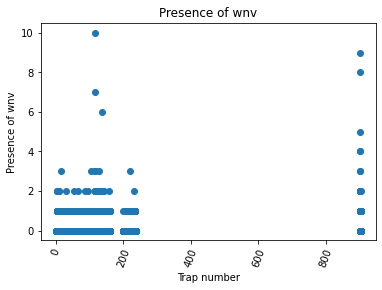

In [26]:
# plot effects of traps
plt.scatter(train['trap'],train['wnvpresent']);
plt.xticks(rotation=70);
plt.title('Presence of wnv');
plt.xlabel('Trap number');
plt.ylabel('Presence of wnv');

In [27]:
train['wnvpresent'].describe()

count    8461.000000
mean        0.065122
std         0.337757
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: wnvpresent, dtype: float64

From the above info, wnvpresent is significantly positive skewed, and majority is '0'. 
<br> Therefore, the decision was to convert trap to ordinal, based on wnvpresent in each trap.

In [28]:
train['wnvpresent'].value_counts()

0     8004
1      409
2       31
3        9
4        2
8        1
9        1
10       1
5        1
6        1
7        1
Name: wnvpresent, dtype: int64

In [29]:
# rank trap
# larger value, more likely to have wnvpresent
def rank_trap(row):
    if row['wnvpresent'] > 4:
        row['trap_rank'] = 4
    elif row['wnvpresent'] == 3:
        row['trap_rank'] = 3
    elif row['wnvpresent'] == 2:
        row['trap_rank'] = 2
    elif row['wnvpresent'] == 1:
        row['trap_rank'] = 1
    else: 
        row['trap_rank'] = 0
    return row  

In [30]:
train = train.apply(rank_trap, axis=1)

In [31]:
train

,date,species_nr,latitude,longitude,addressaccuracy,trap,nummosquitos,wnvpresent,trap_rank
0,2007-05-29,1.0,41.688324,-87.676709,8,86,1,0,0
1,2007-05-29,1.0,41.720848,-87.666014,9,94,3,0,0
2,2007-05-29,1.0,41.731922,-87.677512,8,96,5,0,0
3,2007-05-29,1.0,41.732984,-87.649642,8,159,1,0,0
4,2007-05-29,1.0,41.862292,-87.648860,8,91,1,0,0
...,...,...,...,...,...,...,...,...,...
8456,2013-09-26,3.0,41.960616,-87.777189,9,17,2,0,0
8457,2013-09-26,3.0,41.964242,-87.757639,8,3,3,1,1
8458,2013-09-26,3.0,41.973845,-87.805059,9,223,1,0,0
8459,2013-09-26,3.0,41.974689,-87.890615,9,900,37,0,0


### Baseline Score

Our baseline score is based on the absence of observation of the West Nile Virus. Our basic model provides us:

|score|Probability|Description|
|-----|-----------|-----------|
|Baseline score|<center>94.76%</center>|No West Nile Virus|

In [32]:
train['wnvpresent'].value_counts(normalize=True)

0     0.945987
1     0.048339
2     0.003664
3     0.001064
4     0.000236
8     0.000118
9     0.000118
10    0.000118
5     0.000118
6     0.000118
7     0.000118
Name: wnvpresent, dtype: float64

## Test set 

In [33]:
#preview testdata
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [34]:
# need to predict nummosquitoes and wnvpresent
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [35]:
test.shape

(116293, 11)

### Renamed Column Names to Lowercase



In [36]:
# change column names to lower
test.columns = test.columns.str.lower()

### Change Data Type

We changed the format of ```Column: 'date'``` from ```object``` to ```datetime64[ns]``` to enable the dates to be read appropriately.

In [37]:
# change date to numerical
test['date'] = pd.to_datetime(test['date'])


### Drop Columns

We dropped several columns which provides human-readable identifiers for locations due to redundancy. Since we have latitudes and longitude, human-readable identifiers are not necessary.

Columns Dropped:

    - Address
    - Block
    - Street
    - AddressNumberAndStreet

In [38]:
# Drop columns
test.drop(columns=['address','block','street','addressnumberandstreet'],inplace=True)

### Feature Engineering: Species (Ordinal)

From our exploratory visualizations, we find that while many species of mosquitoes are found, only 2 of those species carry the West Nile Virus: ```Culex Pipiens``` and ```Culex Restuans```. As such, we drop the species which do carry West Nile Virus.

Additionally, we find that there are differences in the frequency of West Nile Virus observed in a species. As such, we engineer a feature to denote the species by the frequency that West Nile Virus is observed.

In [39]:
test['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

In [40]:
test.head()

,id,date,species,trap,latitude,longitude,addressaccuracy
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,9
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,9
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,9
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,9
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,9


In [41]:
test['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

From the above plot, the dominant species carrying the west nile virus are the culex pipiens, culex restuans and culex pipiens/restuans. This parameter will be converted to ordinal. The other species will be dropped.


In [42]:
# Larger value, more likely to have wnvpresent
test['species_nr'] = test['species'].map(mspecies)

In [43]:
# replace other species with '0'
test['species_nr'] = test['species_nr'].fillna(0)

In [44]:
test.drop(columns='species',inplace=True)

In [45]:
test

,id,date,trap,latitude,longitude,addressaccuracy,species_nr
0,1,2008-06-11,T002,41.954690,-87.800991,9,2.0
1,2,2008-06-11,T002,41.954690,-87.800991,9,1.0
2,3,2008-06-11,T002,41.954690,-87.800991,9,3.0
3,4,2008-06-11,T002,41.954690,-87.800991,9,0.0
4,5,2008-06-11,T002,41.954690,-87.800991,9,0.0
...,...,...,...,...,...,...,...
116288,116289,2014-10-02,T054C,41.925652,-87.633590,8,0.0
116289,116290,2014-10-02,T054C,41.925652,-87.633590,8,0.0
116290,116291,2014-10-02,T054C,41.925652,-87.633590,8,0.0
116291,116292,2014-10-02,T054C,41.925652,-87.633590,8,0.0


### Modify Column: Trap

Similar to our train set, we apply a function to combine our trap identifiers.

In [46]:
test['trap'].unique()

array(['T002', 'T007', 'T015', 'T045', 'T046', 'T048', 'T049', 'T050',
       'T054', 'T086', 'T091', 'T094', 'T096', 'T129', 'T143', 'T148',
       'T153', 'T159', 'T009', 'T011', 'T016', 'T019', 'T025', 'T028',
       'T031', 'T033', 'T089', 'T090', 'T092', 'T135', 'T141', 'T142',
       'T145', 'T146', 'T147', 'T149', 'T150', 'T151', 'T152', 'T154',
       'T158', 'T162', 'T218', 'T220', 'T001', 'T003', 'T006', 'T008',
       'T012', 'T034', 'T037', 'T040', 'T043', 'T047', 'T051', 'T085',
       'T088', 'T161', 'T219', 'T013', 'T014', 'T018', 'T030', 'T084',
       'T144', 'T160', 'T005', 'T017', 'T044', 'T095', 'T004', 'T035',
       'T036', 'T039', 'T060', 'T061', 'T062', 'T065', 'T066', 'T067',
       'T069', 'T070', 'T071', 'T073', 'T074', 'T075', 'T076', 'T077',
       'T079', 'T080', 'T081', 'T082', 'T083', 'T114', 'T155', 'T063',
       'T115', 'T138', 'T200', 'T206', 'T209', 'T212', 'T215', 'T107',
       'T128', 'T072', 'T078', 'T097', 'T099', 'T100', 'T102', 'T103',
      

In [47]:
# digitise traps
test = test.apply(trap_digits, axis=1)

In [48]:
train['trap'].equals(test['trap'])

False

trap data in train and test set have different unique values in each dataset.

In [49]:
test['trap_rank'] = test['trap'].replace(train.set_index('trap')['trap_rank'])

In [50]:
test['trap_rank'].unique()

array([  0,   1, 234], dtype=int64)

Turned out the one trap not in training set is trap 234.

In [51]:
# no trap 234 in train set
train[train['trap']== 234]

,date,species_nr,latitude,longitude,addressaccuracy,trap,nummosquitos,wnvpresent,trap_rank


In [52]:
# trap 234 in test set
test[test['trap_rank']== 234]

,id,date,trap,latitude,longitude,addressaccuracy,species_nr,trap_rank
1144,1145,2008-06-11,234,41.942285,-87.761726,8,2.0,234
1145,1146,2008-06-11,234,41.942285,-87.761726,8,1.0,234
1146,1147,2008-06-11,234,41.942285,-87.761726,8,3.0,234
1147,1148,2008-06-11,234,41.942285,-87.761726,8,0.0,234
1148,1149,2008-06-11,234,41.942285,-87.761726,8,0.0,234
...,...,...,...,...,...,...,...,...
116232,116233,2014-10-02,234,41.942285,-87.761726,8,0.0,234
116233,116234,2014-10-02,234,41.942285,-87.761726,8,0.0,234
116234,116235,2014-10-02,234,41.942285,-87.761726,8,0.0,234
116235,116236,2014-10-02,234,41.942285,-87.761726,8,0.0,234


In [53]:
len(test[test['trap_rank']== 234])/len(test)

0.006535217080993697

Trap 234 is 0.6% of test set, and needs to be ranked. Since 95% of the dataset has wnvpresent=0, we will also **rank trap 234 as '0'.**

In [54]:
# rank trap234 as 0
test['trap_rank'] = test['trap_rank'].replace(234,0)

In [55]:
# drop trap
test.drop(columns=['trap'],inplace=True)
train.drop(columns=['trap'],inplace=True)

In [56]:
# ensure no rows were dropped
test.shape

(116293, 7)

## Spray dataset

### Renamed Column Names to Lowercase

In [57]:
# Rename column names to lowercase
spray.columns = spray.columns.str.lower()

### Change Data Type

We changed the format of ```Column: 'date'``` from ```object``` to ```datetime64[ns]``` to enable the dates to be read appropriately.

In [58]:
# Change date to datetime64[ns] format
spray['date'] = pd.to_datetime(spray['date'])

### Drop Column: Time

We observe 584 missing values in ```time```. While knowing both time and dates of the spray may allow us to create a better model, we believe that ```time``` of spray does not materially affect our model as much as the noise it may bring. The noise that ```tiem``` will bring is compounded with our errors if we were to impute the missing time. As such, we believe that it would be better for us to drop the ```time``` column instead of including it into our model.

In [59]:
# View count of null values
spray.isnull().sum()

date           0
time         584
latitude       0
longitude      0
dtype: int64

In [60]:
# Drop time column
spray.drop(columns='time',inplace=True)

### Feature Engineering: Week, Month, Year

We engineered several features based on spray dates. We believe that adding this feature may enable us to have a better view on seasonalities.

In [61]:
spray['week'] = spray['date'].dt.isocalendar().week
spray['month'] = spray['date'].dt.month
spray['year'] = spray['date'].dt.year

### Drop Duplicates

We find that several observations are duplicated. This may be due to several reasons including but not limited to: system malfunction or multiple sprays. We believe that having duplicated observations are redundant and will not improve our model's predictive power. As such, we have dropped these observations. This results in dropping 541 rows.

In [62]:
# drop duplicates
spray.drop_duplicates(keep='first', ignore_index=False, inplace=True)

## Weather Dataset

### Preliminary Changes

#### Renamed Column Names to Lowercase

In [63]:
# Rename column names to lowercase
weather.columns = weather.columns.str.lower()

#### Change Data Type

We changed the format of ```Column: 'date'``` from ```object``` to ```datetime64[ns]``` to enable the dates to be read appropriately.

In [64]:
# change date to numerical
weather['date'] = pd.to_datetime(weather['date'])

#### Fill ```Column: 'tavg'```

We observe that some observations in ```Column: 'tavg'``` are missing. However, none of ```Column: 'tmax'``` and ```Column: 'tmin'``` are missing. We replaced all values of ```Column: 'tavg'``` with the mean of ```Column: 'tmax'``` and ```Column: 'tmin'```.

In [65]:
weather['tavg'] = (weather['tmax'] + weather['tmin']) / 2

#### Drop/Add Columns


|Dropped / Added|Column Name|Remarks|
|-------------|--------------|-----------|
|<center>Dropped</center>|<center>depth<br>water1<br>snowfall</center>|At least 99.6% of the<br>data are missing ('M') or 0|
|<center>Dropped</center>|<center>heat<br>cool</center>|Replaced with 'temp_diff' column|
|<center>Added</center>|<center>temp_diff</center>|Average temperature (tavg) - 65F<br>+ve: Degree(s) above 65F<br>-ve: Degree(s) below 65F



In [66]:
# Drop columns
weather.drop(columns=['depth','water1','snowfall', 'heat', 'cool'],inplace=True)

In [67]:
# Add columns
weather['temp_diff'] = weather['tavg'] - 65

### Missing Data Imputations

We observe that there are many missing values 'M' within our dataframe. We impute the data in two ways:

1. If data is missing  (```M``` or ```-```) from one station, we impute the data from the other station.
2. If data is missing (```M```) from both stations on the same day, we impute frontfill the data from its own station.
3. If data for preciptotal is trace (```T```), we impute ```0.005```.

For example,

|<br><br>Imputation<br><center>Method</center>|<br><br>Column|<br><br>Date|Before<br><br>Station 1|<br><br>Station 2|<br><br>&mdash;>|<br><br>Date|After<br><br>Station 1|<br><br>Station 2|
|-|-|--|-|------|-----|-|-----|-|
|<center>1</center>|wetbulb|2013-08-11|<font color='blue'>M</font>|64|&mdash;>|2013-08-11|<font color='blue'>64</font>|64
|<center>1</center>|wetbulb|2013-08-12|68|<font color='blue'>M</font>|&mdash;>|2013-08-11|68|<font color='blue'>68</font>|
|||||||||
|<center>2</center>|stnpressure|2013-08-09|29.28|29.34|&mdash;>|2013-08-09|29.28|29.34|
|<center>2</center>|stnpressure|2013-08-10|<font color='blue'>M</font>|<font color='blue'>M</font>|&mdash;>|2013-08-10|<font color='blue'>29.28</font>|<font color='blue'>29.34</font>|
||
|<center>3</center>|preciptotal|2007-05-04|<font color='blue'>T</font>|0.00|&mdash;>|2007-05-04|<font color='blue'>0.005</font>|0.00|
|<center>3</center>|preciptotal|2007-06-22|<font color='blue'>T</font>|<font color='blue'>T</font>|&mdash;>|2007-06-22|<font color='blue'>0.005</font>|<font color='blue'>0.005</font>|

<br></br>
**Note: Affected data are colorized <font color='blue'>blue</font> for easier readability.**

#### Imputation Method 1

Columns affected:

    - Depart
    - Preciptotal
    - WetBulb
    - StnPressure
    - SeaLevel
    - AvgSpeed
    - Sunrise
    - Sunset

We would also like to note some findings based on outside research:

Mosquitoes are most active around the time of sunset and sunrise ([source](https://portal.ct.gov/Mosquito/Press-Room/2020-Press-Releases/DPH-Announces-Three-New-Cases-of-West-Nile-Virus-Infection-in-Fairfield-County.)). 

In [68]:
# Replace values from the other station
# [+1] is the next value in the next row (since station 2 is after station 1)
# [-1] is the previous value (since station 1 is before station 2)
def replace_fromstation(row, feature):
    '''replace a M value with a value on the same date, but from the other station'''
    for i in range(len(row)):
        if row[feature][i] == 'M':
            if row['station'][i] == 1:
                row[feature][i] = weather[(weather['date'] == row['date'][i]) & (weather['station'] == 2)][feature][i+1]
            else:
                row[feature][i] = weather[(weather['date'] == row['date'][i]) & (weather['station'] == 1)][feature][i-1]
    return row

# Function to replace all values from station 1
def replace_sun(row):
    '''replace - values with value from station 1'''
    if row['station'] == 2:
        row['sunrise'] = weather[(weather['date'] == row['date']) & (weather['station'] == 1)]['sunrise'].values[0]
        row['sunset'] = weather[(weather['date'] == row['date']) & (weather['station'] == 1)]['sunset'].values[0]
    return row

In [69]:
replace_fromstation(weather, 'depart')
replace_fromstation(weather, 'preciptotal') 
replace_fromstation(weather, 'wetbulb') 
replace_fromstation(weather, 'stnpressure') 
replace_fromstation(weather, 'sealevel') 
replace_fromstation(weather, 'avgspeed') 
weather = weather.apply(replace_sun, axis=1)

In [70]:
# check for 'M' in weather dataframe
for col in weather.select_dtypes(include=['object']).columns:
    print(col, weather[col].str.count('M').sum())

depart 0
wetbulb 0
sunrise 0
sunset 0
codesum 3
preciptotal 0
stnpressure 2
sealevel 0
avgspeed 0


#### Imputation Method 2

Columns affected:

    - StnPressure
    
Unfortunately, on date 2013-08-10, stnpressure were missing in both stations. So this will changed manually. Data on this day, will be replaced from **the day before**.

In [71]:
# Create list of index where stnpressure is missing from both stations on the same day.
idx = weather.index[weather['stnpressure'].str.contains('M')].tolist()

# Frontfill 2 indices before because of the way the dataframe is sorted [station1, station2]
weather['stnpressure'][idx[0]] = weather['stnpressure'][idx[0]-2]
weather['stnpressure'][idx[1]] = weather['stnpressure'][idx[1]-2]

#### Imputation Method 3

Columns affected:

    - PrecipTotal

We replace ```T``` found in ```preciptotal``` to ```0.005```. We note that a 'Trace' precipitation is observed when precipitation is more than 0.00 inch but less than 0.01. We take the midpoint of 0.00 and 0.01 to comply with both restrictions. ([source](https://www.thoughtco.com/measuring-precipitation-1435346))

In [72]:
weather['preciptotal'] = weather['preciptotal'].apply(lambda x: 0.005 if 'T' in x else x)

Warmer temperatures increase viral replication, which can shorten the extrinsic incubation period, increase virus infection and dissemination. This will vary with local temperature and precipitation conditions ([Morin and Comrie 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3785720/)).

### Feature Engineering

We conduct several feature engineering which we believe will benefit our final model.

#### Feature: Week, Month, Year

We engineered several features based on the observed weather dates. We believe that adding this feature may enable us to have a better view on seasonalities.

In [73]:
weather['week'] = weather['date'].dt.isocalendar().week
weather['month'] = weather['date'].dt.month
weather['year'] = weather['date'].dt.year

In [74]:
weather[['date','week','month','year']]

,date,week,month,year
0,2007-05-01,18,5,2007
1,2007-05-01,18,5,2007
2,2007-05-02,18,5,2007
3,2007-05-02,18,5,2007
4,2007-05-03,18,5,2007
...,...,...,...,...
2939,2014-10-29,44,10,2014
2940,2014-10-30,44,10,2014
2941,2014-10-30,44,10,2014
2942,2014-10-31,44,10,2014


#### Feature: Thunderstorm and Fog

Thunderstorms and hot humid days are perfect setups for mosquitoes to appear ([source](https://www.iaff.org/west-nile-virus/)). On the other hand, mosquitoes are not well conditioned for flight in foggy days ([source](https://www.sciencedaily.com/releases/2012/11/121119104522.htm)). As such, we created two features, ```TS``` and ```FG```, based on the presence of ```TS``` and ```FG``` or ```FG+``` in ```Column: codesum``` respectively.
While we observe 1645 empty values, we infer that no significant weather phenomena was observed in those days, i.e. it was a normal day. 

|Dropped / Added|Column Name|Remarks|
|-------------|--------------|-----------|
|<center>Added</center>|<center>TS</center>|Significant weather type: Thunderstorm|
|<center>Added</center>|<center>FG</center>|Significant weather type: Fog / Heavy Fog|
|<center>Dropped</center>|<center>codesum</center>|We believe that our engineered features ```TS``` and<br>```FG``` are sufficient in improving our overall model.

In [75]:
weather.loc[weather['codesum'].str.contains('FG'), 'FG'] = 1
weather.loc[weather['codesum'].str.contains('TS'), 'TS'] = 1
weather['TS'] = weather['TS'].fillna(0)
weather['FG'] = weather['FG'].fillna(0)
weather.drop(columns=['codesum'],inplace=True)

### Combine Station 1 and 2 data

Wherever possible, we convert our data types to a ```float``` to enable proper code reading. We then combine the datasets by taking the mean of both station values. Lastly, we drop the ```Column: station``` as we have combined the data provided in both datasets.

In [76]:
# convert data to numerical
for col in weather.columns:
    try:
        weather[col] = weather[col].astype(float)
    except:
        print(col, 'cannot be converted to numerical')
        pass

date cannot be converted to numerical


In [77]:
# combine stations 1 and 2
weather = weather.groupby('date').sum()/ 2
weather = weather.drop(columns=['station']).reset_index()

In [78]:
weather

,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,sunrise,sunset,preciptotal,...,sealevel,resultspeed,resultdir,avgspeed,temp_diff,week,month,year,FG,TS
0,2007-05-01,83.5,51.0,67.25,14.0,51.0,56.5,448.0,1849.0,0.0000,...,29.820,2.20,26.0,9.40,2.25,18.0,5.0,2007.0,0.0,0.0
1,2007-05-02,59.5,42.5,51.00,-3.0,42.0,47.0,447.0,1850.0,0.0000,...,30.085,13.15,3.0,13.40,-14.00,18.0,5.0,2007.0,0.0,0.0
2,2007-05-03,66.5,47.0,56.75,2.0,40.0,49.0,446.0,1851.0,0.0000,...,30.120,12.30,6.5,12.55,-8.25,18.0,5.0,2007.0,0.0,0.0
3,2007-05-04,72.0,50.0,61.00,4.0,41.5,50.0,444.0,1852.0,0.0025,...,30.045,10.25,7.5,10.60,-4.00,18.0,5.0,2007.0,0.0,0.0
4,2007-05-05,66.0,53.5,59.75,5.0,38.5,49.5,443.0,1853.0,0.0050,...,30.095,11.45,7.0,11.75,-5.25,18.0,5.0,2007.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,78.0,52.5,65.25,16.0,51.5,58.5,618.0,1653.0,0.0100,...,29.665,12.35,19.0,13.25,0.25,44.0,10.0,2014.0,0.0,0.0
1468,2014-10-28,67.0,46.5,56.75,10.0,39.0,47.5,619.0,1651.0,0.0175,...,29.850,14.40,26.0,15.10,-8.25,44.0,10.0,2014.0,0.0,0.0
1469,2014-10-29,49.0,38.0,43.50,-4.0,33.0,41.0,620.0,1650.0,0.0000,...,30.065,9.00,29.0,9.45,-21.50,44.0,10.0,2014.0,0.0,0.0
1470,2014-10-30,52.0,34.5,43.25,-4.0,34.5,41.0,622.0,1649.0,0.0025,...,30.095,5.50,23.5,6.00,-21.75,44.0,10.0,2014.0,0.0,0.0


#### Feature: Temperature and percipitation lag

Increased precipitation and temperatures have a lagged effect on wnvpresent ([source](https://pubmed.ncbi.nlm.nih.gov/30145430/)). Since the culex mosquito life cycle is about 7-10 days from hatching to adulthood ([source](https://www.cdc.gov/westnile/resources/pdfs/FS_MosquitoLifeCycle-508.pdf)), these lagged features could be a predictive factor to wnvpresent.
<br>
<br> Therefore, a lag of 7 and 14 days were applied to the 'tavg' and 'preciptotal' features.



In [79]:
weather.set_index('date')
weather['lag_1_tavg'] = weather['tavg'].shift(-7)
weather['lag_2_tavg'] = weather['tavg'].shift(-14)

weather['lag_1_preciptotal'] = weather['preciptotal'].shift(-7)
weather['lag_2_preciptotal'] = weather['preciptotal'].shift(-14)


In [80]:
weather.reset_index()

,index,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,sunrise,sunset,...,temp_diff,week,month,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal
0,0,2007-05-01,83.5,51.0,67.25,14.0,51.0,56.5,448.0,1849.0,...,2.25,18.0,5.0,2007.0,0.0,0.0,69.00,68.75,0.0025,0.490
1,1,2007-05-02,59.5,42.5,51.00,-3.0,42.0,47.0,447.0,1850.0,...,-14.00,18.0,5.0,2007.0,0.0,0.0,69.25,54.75,0.0750,0.105
2,2,2007-05-03,66.5,47.0,56.75,2.0,40.0,49.0,446.0,1851.0,...,-8.25,18.0,5.0,2007.0,0.0,0.0,70.50,52.50,0.0000,0.000
3,3,2007-05-04,72.0,50.0,61.00,4.0,41.5,50.0,444.0,1852.0,...,-4.00,18.0,5.0,2007.0,0.0,0.0,60.75,56.50,0.0000,0.000
4,4,2007-05-05,66.0,53.5,59.75,5.0,38.5,49.5,443.0,1853.0,...,-5.25,18.0,5.0,2007.0,0.0,0.0,55.50,68.00,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,1467,2014-10-27,78.0,52.5,65.25,16.0,51.5,58.5,618.0,1653.0,...,0.25,44.0,10.0,2014.0,0.0,0.0,NaN,NaN,NaN,NaN
1468,1468,2014-10-28,67.0,46.5,56.75,10.0,39.0,47.5,619.0,1651.0,...,-8.25,44.0,10.0,2014.0,0.0,0.0,NaN,NaN,NaN,NaN
1469,1469,2014-10-29,49.0,38.0,43.50,-4.0,33.0,41.0,620.0,1650.0,...,-21.50,44.0,10.0,2014.0,0.0,0.0,NaN,NaN,NaN,NaN
1470,1470,2014-10-30,52.0,34.5,43.25,-4.0,34.5,41.0,622.0,1649.0,...,-21.75,44.0,10.0,2014.0,0.0,0.0,NaN,NaN,NaN,NaN


In [81]:
# replace NaN with most recent values. 
weather.loc[weather['lag_1_tavg'].isnull(), 'lag_1_tavg'] = weather['tavg'].iloc[-8]
weather.loc[weather['lag_2_tavg'].isnull(), 'lag_2_tavg'] = weather['tavg'].iloc[-15]
weather.loc[weather['lag_1_preciptotal'].isnull(), 'lag_1_preciptotal'] = weather['preciptotal'].iloc[-8]
weather.loc[weather['lag_2_preciptotal'].isnull(), 'lag_2_preciptotal'] = weather['preciptotal'].iloc[-15]

# Combined dataset

### Train and weather dataset

In [82]:
# merge training dataframes
train_merge = pd.merge(train, weather, on='date', how='inner')

In [83]:
train_merge.shape

(8461, 32)

In [84]:
pd.set_option('display.max_columns',30)
train_merge

,date,species_nr,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,trap_rank,tmax,tmin,tavg,depart,dewpoint,wetbulb,sunrise,...,stnpressure,sealevel,resultspeed,resultdir,avgspeed,temp_diff,week,month,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal
0,2007-05-29,1.0,41.688324,-87.676709,8,1,0,0,88.0,62.5,75.25,10.0,58.5,65.5,421.0,...,29.415,30.10,5.80,17.0,6.95,10.25,22.0,5.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
1,2007-05-29,1.0,41.720848,-87.666014,9,3,0,0,88.0,62.5,75.25,10.0,58.5,65.5,421.0,...,29.415,30.10,5.80,17.0,6.95,10.25,22.0,5.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
2,2007-05-29,1.0,41.731922,-87.677512,8,5,0,0,88.0,62.5,75.25,10.0,58.5,65.5,421.0,...,29.415,30.10,5.80,17.0,6.95,10.25,22.0,5.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
3,2007-05-29,1.0,41.732984,-87.649642,8,1,0,0,88.0,62.5,75.25,10.0,58.5,65.5,421.0,...,29.415,30.10,5.80,17.0,6.95,10.25,22.0,5.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
4,2007-05-29,1.0,41.862292,-87.648860,8,1,0,0,88.0,62.5,75.25,10.0,58.5,65.5,421.0,...,29.415,30.10,5.80,17.0,6.95,10.25,22.0,5.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,2013-09-26,3.0,41.960616,-87.777189,9,2,0,0,75.0,52.5,63.75,3.0,52.0,58.0,543.0,...,29.370,30.04,3.95,8.5,4.40,-1.25,39.0,9.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0
8457,2013-09-26,3.0,41.964242,-87.757639,8,3,1,1,75.0,52.5,63.75,3.0,52.0,58.0,543.0,...,29.370,30.04,3.95,8.5,4.40,-1.25,39.0,9.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0
8458,2013-09-26,3.0,41.973845,-87.805059,9,1,0,0,75.0,52.5,63.75,3.0,52.0,58.0,543.0,...,29.370,30.04,3.95,8.5,4.40,-1.25,39.0,9.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0
8459,2013-09-26,3.0,41.974689,-87.890615,9,37,0,0,75.0,52.5,63.75,3.0,52.0,58.0,543.0,...,29.370,30.04,3.95,8.5,4.40,-1.25,39.0,9.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0


In [85]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8461 entries, 0 to 8460
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               8461 non-null   datetime64[ns]
 1   species_nr         8461 non-null   float64       
 2   latitude           8461 non-null   float64       
 3   longitude          8461 non-null   float64       
 4   addressaccuracy    8461 non-null   int64         
 5   nummosquitos       8461 non-null   int64         
 6   wnvpresent         8461 non-null   int64         
 7   trap_rank          8461 non-null   int64         
 8   tmax               8461 non-null   float64       
 9   tmin               8461 non-null   float64       
 10  tavg               8461 non-null   float64       
 11  depart             8461 non-null   float64       
 12  dewpoint           8461 non-null   float64       
 13  wetbulb            8461 non-null   float64       
 14  sunrise 

#### Seasonal differences

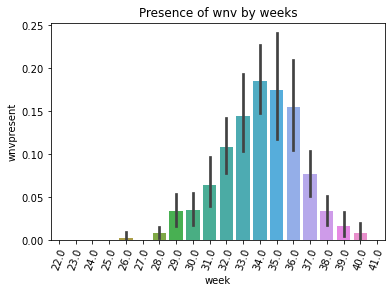

In [86]:
# effects of weeks
sns.barplot(data=train_merge, x='week', y='wnvpresent');
plt.xticks(rotation=70);
plt.title('Presence of wnv by weeks');

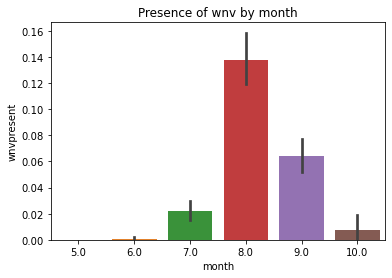

In [87]:
# effects of months
sns.barplot(data=train_merge, x='month', y='wnvpresent');
plt.title('Presence of wnv by month');

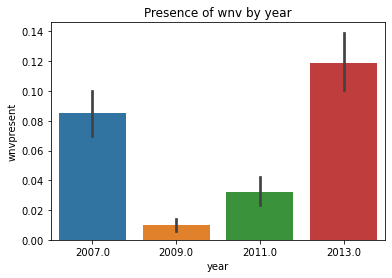

In [88]:
# effects of year
sns.barplot(data=train_merge, x='year', y='wnvpresent');
plt.title('Presence of wnv by year');

From the above plots, August is the highest month with the highest presence of west nile virus being detected. August corresponds with week 31-35. 
<br>
<br> Weeks would be kept (instead of months) since it looked more like a normal distribution. But year is interesting as well. 
<br>
<br> Years 2007 and 2013 are years with the highest presence of west nile virus detected. This needs to be explored further. In 2007, this could be due to a large amount of rain and hot weather, which produced favourable conditions for eggs ([source](https://www.cmaj.ca/content/177/12/1489.1)). 2012/2013 was the deadliest year for the wnv in the US, resulting from factors such as higher than normal temperatures that influenced mosquito and bird (reservoir hosts) abundance ([source](https://www.nbcnews.com/healthmain/2012-was-deadliest-year-west-nile-us-cdc-says-1c9904312)). 

#### Correlation heatmap


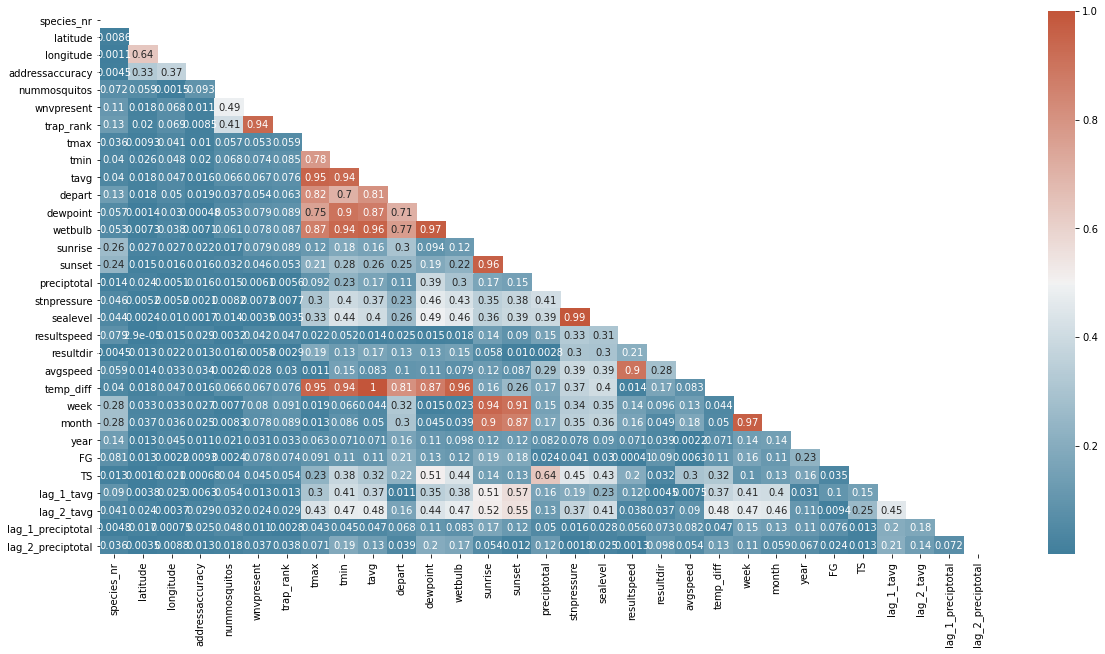

In [89]:
# plotting correlation with wnvpresent
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(np.abs(train_merge.corr()), dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(np.abs(train_merge.corr()),
            cmap=cmap,
            mask=mask,
            annot=True,
            fmt='.2g'
           );


**temperature**
<br>From the heatmap above, there are obvious linearity between tmin, tmax, and tavg. Other features like dewpoint, wetbulb, depart and temp_diff are also correlated with temperature. This is not surprising - the wet-bulb temperature is the temperature indicated by a moistened thermometer bulb exposed to the air flow. This is related to humidity, since the difference between wetbulb and the ambient temperature is a measure of humidity in the air. Since wetbulb takes into account both precipitation and temperature, it might have better predictive power since it is a feature engineered through combining temperature and precipitation ([source](https://www.theweatherprediction.com/habyhints/259/)). Another feature 'depart' is the temperature departing from the normal base temperature. 
<br>
<br>
**precipitation**
<br> TS or thunderstorm occuring is correlated with preciptotal. This is expected since thunderstorms are usually accompanied by heavy winds and rain. dewpoint which is the temperature at which air must be cooled to become saturated with water vapor, and wetbulb also have some association with precipitation. In addition, dewpoint and wetbulb, in turn, are correlated with each other. In summary, the features especially those in the weather dataset are correlated with each other. Thus, we have multicollinearity in our merged dataset. 

To have a better overview of the correlation to wnvpresent, the below table lists possible features that may be important in determining wnvpresent.

In [90]:
traincorr = train_merge.corr().abs()
traincorr.loc[traincorr['wnvpresent']>=0.05,['wnvpresent']].sort_values(by=['wnvpresent'],ascending=False)

,wnvpresent
wnvpresent,1.000000
trap_rank,0.939675
nummosquitos,0.485048
species_nr,0.113105
week,0.079692
dewpoint,0.079406
sunrise,0.079328
FG,0.077827
month,0.077581
wetbulb,0.077568


#### Weekly plots

In [91]:
# create dataframe for plotting
train_merge_plot = train_merge.groupby('week').mean()

train_merge_plot = train_merge_plot.reset_index()

In [92]:
train_merge_plot.head()

,week,species_nr,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,trap_rank,tmax,tmin,tavg,depart,dewpoint,wetbulb,sunrise,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,temp_diff,month,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal
0,22.0,1.604938,41.841903,-87.684397,7.901235,2.839506,0.000000,0.000000,70.716049,56.969136,63.842593,-0.370370,53.314815,57.549383,421.000000,...,0.000000,29.186852,29.861481,6.491358,25.641975,7.814198,-1.157407,5.0,2008.382716,0.0,0.000000,56.250000,62.361111,0.106481,0.397531
1,23.0,1.520588,41.853738,-87.707820,8.058824,6.423529,0.000000,0.000000,67.922059,49.239706,58.580882,-7.120588,46.700000,52.576471,417.417647,...,0.144507,29.252338,29.940147,7.173824,7.914706,8.220294,-6.419118,6.0,2009.705882,0.0,0.061765,65.805882,71.363235,0.002721,1.062794
2,24.0,1.533569,41.855863,-87.704142,8.095406,13.088339,0.000000,0.000000,77.466431,56.213781,66.840106,-1.519435,53.261484,58.929329,416.000000,...,0.001537,29.266325,29.939470,5.553710,6.146643,6.866254,1.840106,6.0,2011.091873,0.0,0.000000,72.094523,77.783569,0.902968,0.030848
3,25.0,1.513699,41.844275,-87.694170,7.863014,10.996575,0.000000,0.000000,80.083904,64.489726,72.286815,1.561644,61.669521,65.094178,416.277397,...,0.888048,29.179110,29.854110,7.604281,20.787671,9.719863,7.286815,6.0,2010.965753,0.0,0.477740,77.728596,72.936644,0.035625,0.000000
4,26.0,1.488943,41.861691,-87.707347,8.083538,16.157248,0.002457,0.002457,86.125307,66.149877,76.137592,4.223587,62.522113,67.264128,418.437346,...,0.141529,29.235491,29.907592,7.485381,16.362408,8.526044,11.137592,6.0,2009.938575,0.0,0.212531,72.473587,73.000614,0.050012,0.064607


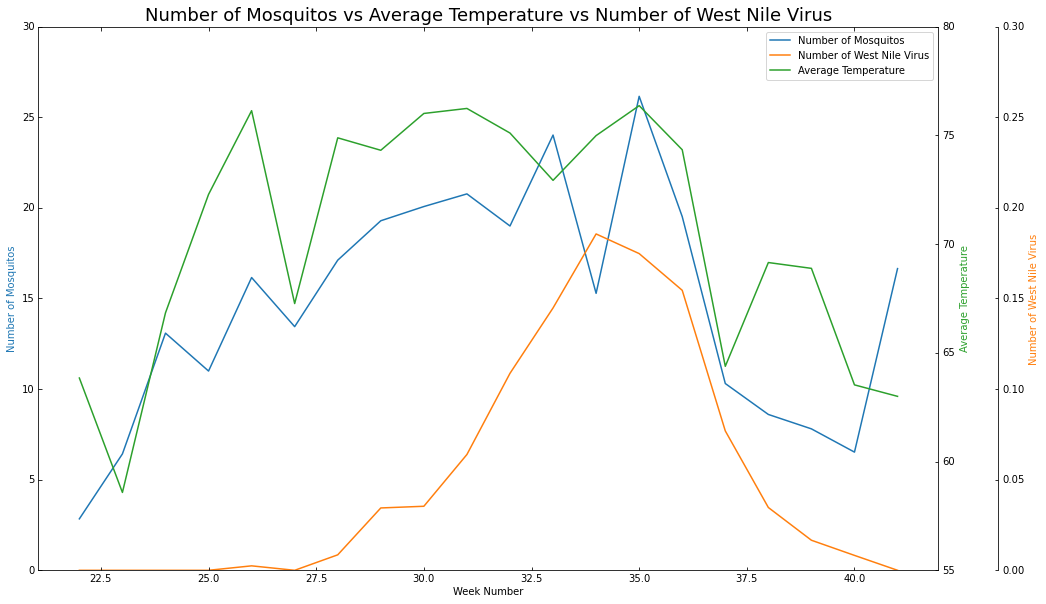

In [93]:
plt.figure(figsize=(20, 10))
host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par1.axis["right"] = par1.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

p1, = host.plot(train_merge_plot['week'], 
                train_merge_plot['nummosquitos'], 
                label="Number of Mosquitos")

p2, = par1.plot(train_merge_plot['week'], 
                train_merge_plot['wnvpresent'], 
                label="Number of West Nile Virus")


p3, = par2.plot(train_merge_plot['week'],
                train_merge_plot['tavg'], 
                label="Average Temperature")

host.set_ylim(0, 30)
par1.set_ylim(0, 0.3)
par2.set_ylim(55, 80)


host.set_xlabel("Week Number")
host.set_ylabel("Number of Mosquitos")
par1.set_ylabel("Number of West Nile Virus")
par2.set_ylabel("Average Temperature")

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

plt.title('Number of Mosquitos vs Average Temperature vs Number of West Nile Virus',
          fontdict={'fontsize': 18}
         )

plt.show()

The graph above shows the trends between average temperature (green line), average number of mosquitos caught (blue line) and the proportion of WNV present (orange line) on a weekly basis. This is in agreement with an [article](https://mosquitoreviews.com/learn/mosquito-season/) on the effect of temperature on mosquito life cycle:

>The warm temperatures make (mosquitos) pass through their life cycle faster, so more are laying eggs and more eggs are hatching.

This is evident in the graph above, where the number of mosquitoes caught increases as average daily temperature increases. We believe that the number of mosquitoes caught is a suitable proxy to estimate the number of mosquitoes in the general area. As such, we can reasonably conclude that rising average temperature results in higher mosquito prevalence.

In addition, we find that the prevalence of WNV gradually increases on week 27 (end of June), peaks in week 34 (August) and slowly decreases until about week 41 (October). This is in line with the [CDC’s findings](https://www.cdc.gov/westnile/index.html) which states that:

>“Cases of WNV occur during mosquito season, which starts in the summer and continues through fall.”

Overall, this graph demonstrates two important points:
1. As temperature increases, so does the number of mosquitoes.
2. As the number of mosquitoes increase, so do the number of mosquitoes carrying WNV.

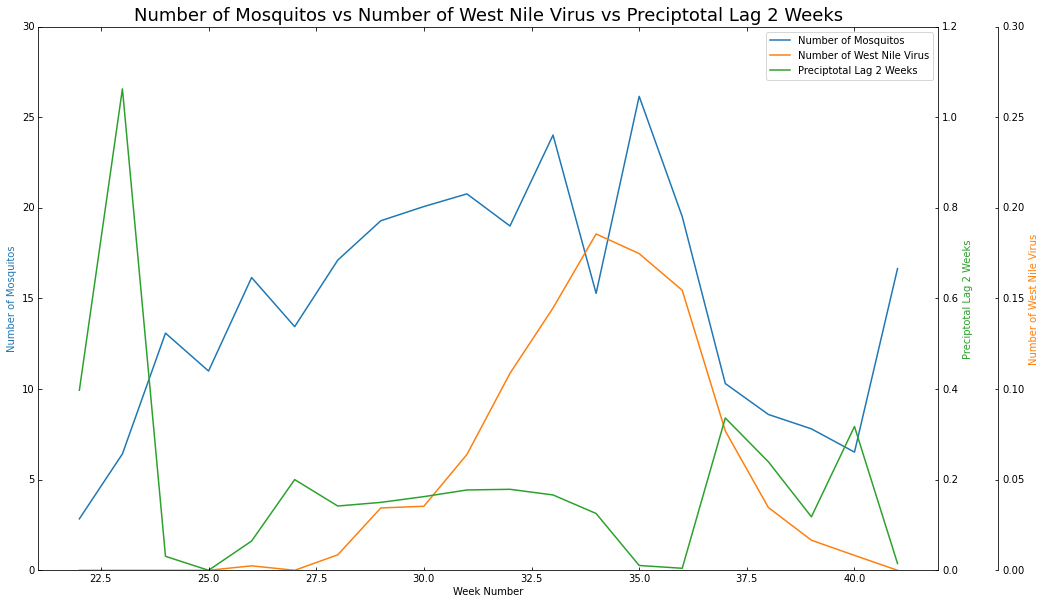

In [94]:
plt.figure(figsize=(20, 10))
host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par1.axis["right"] = par1.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

p1, = host.plot(train_merge_plot['week'], 
                train_merge_plot['nummosquitos'], 
                label="Number of Mosquitos")

p2, = par1.plot(train_merge_plot['week'], 
                train_merge_plot['wnvpresent'], 
                label="Number of West Nile Virus")


p3, = par2.plot(train_merge_plot['week'],
                train_merge_plot['lag_2_preciptotal'], 
                label="Preciptotal Lag 2 Weeks")

host.set_ylim(0, 30)
par1.set_ylim(0, 0.3)
par2.set_ylim(0, 1.2)

host.set_xlabel("Week Number")
host.set_ylabel("Number of Mosquitos")
par1.set_ylabel("Number of West Nile Virus")
par2.set_ylabel("Preciptotal Lag 2 Weeks")

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

plt.title('Number of Mosquitos vs Number of West Nile Virus vs Preciptotal Lag 2 Weeks',
          fontdict={'fontsize': 18}
         )

plt.show()

The graph above shows the trends between 2-week lagged total precipitation (green line), average number of mosquitos caught (blue line) and the proportion of WNV present (orange line) on a weekly basis throughout the training years. We observe that the number of mosquitoes caught is inversely correlated to the 2-week lagged total precipitation. This finding is corroborated by [Ruiz et al., 2010](https://parasitesandvectors.biomedcentral.com/articles/10.1186/1756-3305-3-19), where they demonstrated that:

> (There is) a relationship with both low precipitation and higher temperatures and increased numbers of human WNV cases

From the two graphs above and supported by our earlier references, we believe that these two variables/features will play a major role in providing our model with better predictive ability. 

### Spray with train/weather dataset

Spray dataset is from 2011 to 2013, and weather dataset has data in year 2011 and 2013. So there is limited information at how effective spraying was on the presence of wnv. 
<br>


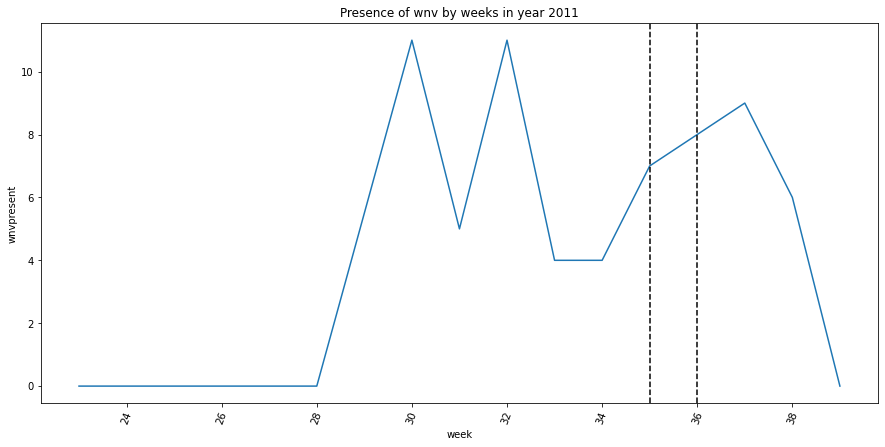

In [95]:
plt.figure(figsize=(15, 7))
plotting2011 = train_merge[train_merge['year']==2011].groupby(['week'])['wnvpresent'].sum().reset_index()
sns.lineplot(x=plotting2011['week'], y=plotting2011['wnvpresent'])
for week in spray[spray['year'] == 2011].groupby('week').mean().index:
    plt.axvline(x=week, color='k', linestyle='--')
plt.xticks(rotation=70);
plt.title('Presence of wnv by weeks in year 2011');

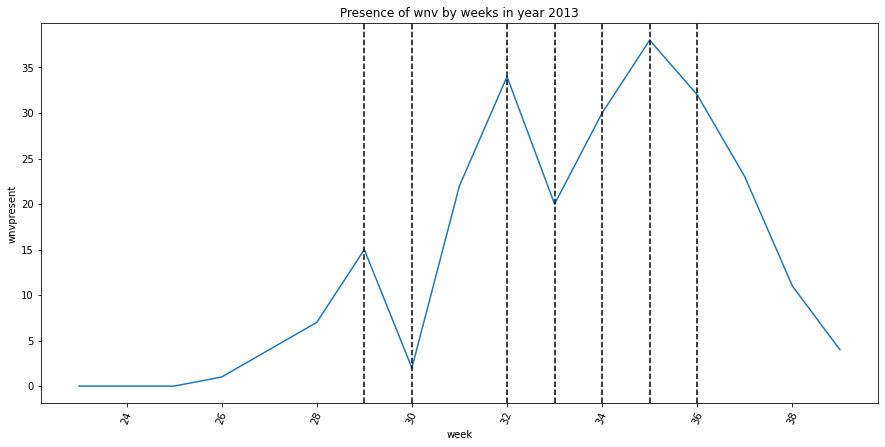

In [96]:
plt.figure(figsize=(15, 7))
plotting2013 = train_merge[train_merge['year']==2013].groupby(['week'])['wnvpresent'].sum().reset_index()
sns.lineplot(x=plotting2013['week'], y=plotting2013['wnvpresent'])
for week in spray[spray['year'] == 2013].groupby('week').mean().index:
    plt.axvline(x=week, color='k', linestyle='--')
plt.xticks(rotation=70);
plt.title('Presence of wnv by weeks in year 2013');

Plots above showed the presence of wnv by weeks with periods of spraying (dotted vertical lines) for year 2011 and 2013. In the year 2011, the period of spraying in weeks 35 and 36 has little/no effect on wnv. For year 2013, spraying took place at some peaks and troughs of wnv. Since the culex mosquito life cycle is about 7-10 days from hatching to adulthood ([source](https://www.cdc.gov/westnile/resources/pdfs/FS_MosquitoLifeCycle-508.pdf)), there is perhaps a delay from the effects of spraying.
<br>
<br> So does spraying affect the number of mosquitoes?


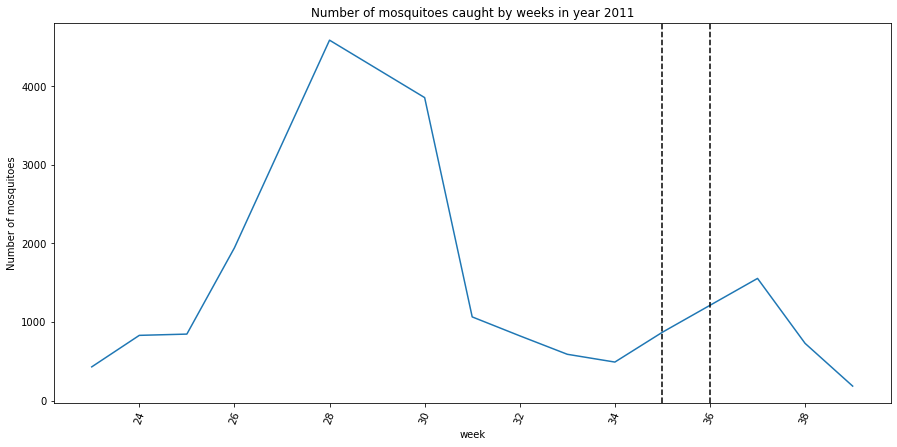

In [97]:
plt.figure(figsize=(15, 7))
plottingnum2011 = train_merge[train_merge['year']==2011].groupby(['week'])['nummosquitos'].sum().reset_index()
sns.lineplot(x=plottingnum2011['week'], y=plottingnum2011['nummosquitos'])
for week in spray[spray['year'] == 2011].groupby('week').mean().index:
    plt.axvline(x=week, color='k', linestyle='--')
plt.xticks(rotation=70);
plt.ylabel('Number of mosquitoes')
plt.title('Number of mosquitoes caught by weeks in year 2011');

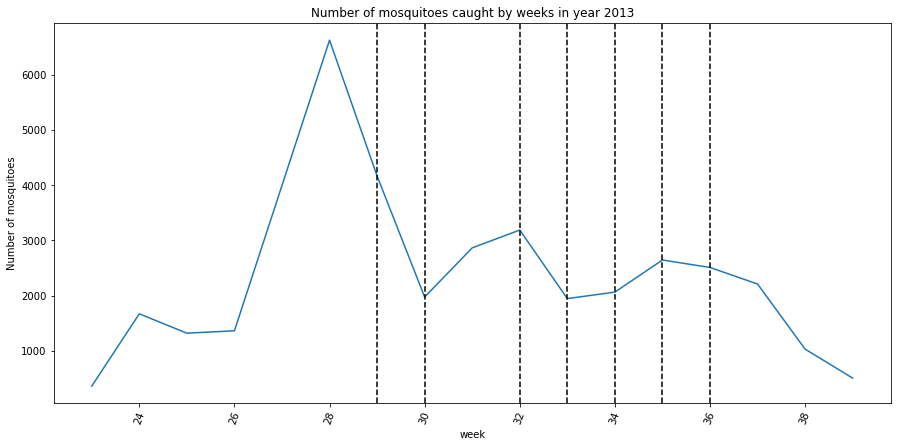

In [98]:
plt.figure(figsize=(15, 7))
plottingnum2013 = train_merge[train_merge['year']==2013].groupby(['week'])['nummosquitos'].sum().reset_index()
sns.lineplot(x=plottingnum2013['week'], y=plottingnum2013['nummosquitos'])
for week in spray[spray['year'] == 2013].groupby('week').mean().index:
    plt.axvline(x=week, color='k', linestyle='--')
plt.xticks(rotation=70);
plt.ylabel('Number of mosquitoes')
plt.title('Number of mosquitoes caught by weeks in year 2013');

The above plots showed that the number of mosquitoes decreased one week (or approximately 7-10days) after spraying. So it is likely that spraying does have an effect of the number of mosquitoes caught. This discussion is further expanded below in the analysing the cost-effectiveness of spraying.

### Spray locations


In mapping our spray data, we find that there were spray areas outside our area of concern. Therefore, we dropped these observations. This results in the elimination of 95 rows.

In [99]:
spray.loc[spray['longitude'] < -88]

,date,latitude,longitude,week,month,year
0,2011-08-29,42.391623,-88.089163,35,8,2011
1,2011-08-29,42.391348,-88.089163,35,8,2011
2,2011-08-29,42.391022,-88.089157,35,8,2011
3,2011-08-29,42.390637,-88.089158,35,8,2011
4,2011-08-29,42.390410,-88.088858,35,8,2011
...,...,...,...,...,...,...
90,2011-08-29,42.392902,-88.093853,35,8,2011
91,2011-08-29,42.392587,-88.093867,35,8,2011
92,2011-08-29,42.392308,-88.093873,35,8,2011
93,2011-08-29,42.392183,-88.093767,35,8,2011


In [100]:
spray.drop(spray.loc[spray['longitude'] < -88].index, inplace=True)

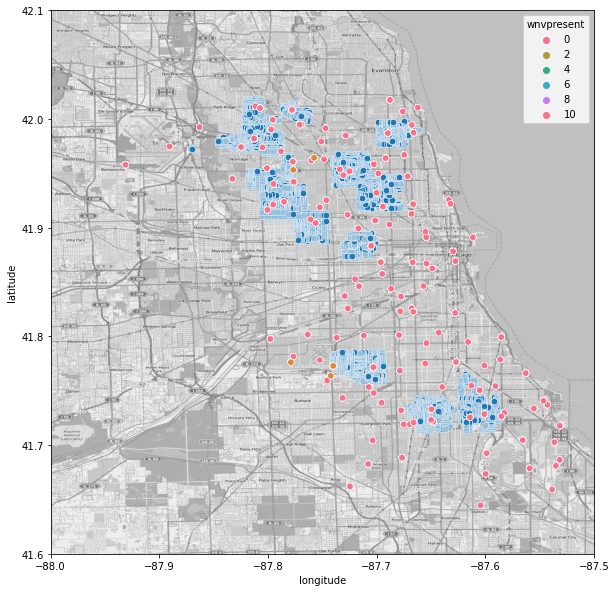

In [101]:
# https://www.kaggle.com/c/predict-west-nile-virus/
# This shows how to read the text representing a map of Chicago in numpy, and put it on a plot in matplotlib.
# This example also rescales the image data to the GPS co-ordinates of the bounding box and overlays some random points.

origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

mapdata = np.loadtxt('../data/mapdata_copyright_openstreetmap_contributors.txt')

# generate some data to overlay
numPoints = 300
lats = spray['latitude']
longs = spray['longitude']
wnv = train_merge['wnvpresent']
lats_2 = train_merge['latitude']
longs_2 = train_merge['longitude']

plt.figure(figsize=(10,10))

# generate plot
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
sns.scatterplot(x=longs, y=lats, 
                s=40)
sns.scatterplot(x=longs_2, y=lats_2, palette='husl', 
                c='k', 
                hue=wnv, 
                s=40)

#plt.show()
plt.savefig('map_spray.png')


The above map shows areas sprayed (blue clouded regions) and areas where wnv were detected (vomit green points, not pink ones). It showed that spraying does have effect on wnv, since the vomit green points were not in areas of spraying. 

### Cost-effectiveness of spraying

This year, the Chicago Department of Public Health (CHPH) has begun its annual mosquito control activities from May 26. This includes treating 40,000 catch basins with larvicide, which kills immature mosquitoes ([source](https://www.chicago.gov/city/en/depts/cdph/provdrs/health_protection_and_response/news/2021/july/cdph-conducts-a-comprehensive-mosquito-surveillance-and-control-.html)). This was found to be most effective than insecticide spraying ([source](https://www.chicago.gov/dam/city/depts/cdph/comm_dis/general/Communicable_Disease/CD_CDInfo_Jun07_WNV.pdf)). They are expected to monitor the areas where mosquitoes tested were found to be positive for WNV and will determine the appropriate next steps to be taken following additional tests. 

The Centers for Disease Control and Prevention (CDC) summarizes the reported number of WNV cases for each state, where the diagnosis, and outcome (fatality) were reported. The table belows shows the number of cases and deaths in the state of Illinois according to the CDC database ([source](https://www.cdc.gov/westnile/statsmaps/finalmapsdata/index.html)). The table is similar to our earlier plot showing the seasonal differences of wnvpresent by year. 

| year | wnv | deaths |
|------|-----|--------|
| 2007 | 101 | 4      |
| 2009 | 5   | 0      |
| 2011 | 34  | 3      |
| 2013 | 117 | 12     |

The CDC has reported that from 2000-2014, hospitalised cases of WNV have cost a cumulative US\\$778 million in direct and indirect medical costs ([source](https://www.sciencedaily.com/releases/2014/02/140210184713.htm)). Therefore, a short-term
economic assessment of the costs associated with WNV should be examined. This includes assessing the costs of strengthening or maintaining prevention measures to limit the spread of WNV. This is especially so given current ongoing covid19 epidemic, where the vaccination rate in Illinois is at 54\%, and some counties reported 'warning level' for ICU bed capacity ([source](https://www.nbcchicago.com/news/coronavirus/37-illinois-counties-chicago-are-at-warning-level-for-icu-availability-idph-data-shows/2597233/)). The first death this year from WNV in Chicago Illinois, was reported on Oct 9 ([source](https://abc7chicago.com/illinois-west-nile-mosquito-chicago/11100118/)).

**Direct medical costs**
<br> To approximate direct medical costs, we referred to previous studies by [Barber et al., 2010](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/) and [Zohrabian et al., 2002](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/) to approximate inpatient costs based on the length of hospital stay, treatment charges and miscellaneous costs. Please note that the values in the table below were estimated based on Medicare cost-to-charge ratio for Louisiana (0.41) in 2002 and California (0.42) in 2005 to derive an estimate of reimbursed costs. It is understandable that given inflation and costs adjustment due to the Consumer Price Index, costs per patient per category are expected to be different for current years. Nonetheless, this is a good approximation for direct medical costs incurred by 119 patients due to WNV. 
<br> 
<br>This was similar to the figures reported by the state of California for the year 2005 where total medical costs accrued by WNV patients was approximately US\\$2,140,409 ([Barber et al., 2010](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/)) . If we were to assume the medical costs for hospitalised patients with WNV in Louisiana was similar to the number of patients in Illinois with a similar cost-to-charge ratio, the below table will be the approximate economic costs due to WNV. On average, the cost for each patient that receives chronic care for West Nile virus is US\\$17,680. Please note this is a gross approximation, based on available information found.  

| Per patient costs (US$)    |     |        |             |           |
|----------------------------|-----|--------|-------------|-----------|
| Treatment/Service category | n   | median | range       | total     |
| Pharmacy/Medical supplies  | 115 | 2,934  | 16-88,825   | 887,759   |
| Diagnostic                 | 118 | 2,417  | 95-42,064   | 547,935   |
| Room and board             | 117 | 1,132  | 52-16,445   | 237,917   |
| Medical/Surgical services  | 75  | 675    | 15-21,606   | 200,233   |
| Intensive care             | 24  | 5,526  | 439-17,769  | 162,360   |
| Rehabilitation             | 35  | 425    | 71-4,202    | 32,947    |
| Emergency services         | 79  | 271    | 90-1,516    | 25,947    |
| Other                      | 33  | 109    | 1-2,620     | 8,873     |
| Total                      | 119 | 8,274  | 623-164,668 | 2,103,971 |

**Outpatient costs**
<br> Not all WNV patients needed to be hospitalised, or they may just require additional outpatient treatment. Similarly, referring to [Zohrabian et al., 2002](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/), they estimated that the estimated total cost of visits to see a primary care doctor, specialist, or both for 139 patients (who responded to the survey) requiring outpatient treatments was US\\$54,572. On average, the cost for each patient that receives outpatient care for West Nile virus is US$393. Please note this is a gross approximation, based on available information found. 

**Indirect costs**
<br> Other nonmedical costs include nursing home, transportation, home-health aides, child care costs, and productivity losses (from illness and death). Cost for each patient requiring to spend time in a nursing home was US\\$18,097. Productivity loss during cost US\\$10,800 per patient <60 years of age and US\\$$7,500 per patient >60 years of age ([Barber et al., 2010](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/)).

**Total costs for emergency aerial spray response**
<br> For Sacramento, California, costs of spray including overtime hours costs approximately US$\\$641,790 ([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/)). Louisiana central state public health office reported spending an estimated US\\$886,000 ([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3323281/)).  Since Chicago is 2.3 times larger than Sacramento, this will approximately be US\\$1,507,460. Please note this is a gross approximation, based on available information found.  

Despite these highly grossly estimated costs, there is a high chance that these costs were underestimated, and we may never really know the actual costs due to the WNV outbreak. Pain, distress, emotional loss are also factors that cannot be put into dollars and cents. Furthermore, there could be unreported cases since CDC also reported presumptive viremic blood donors who had no symptoms at the time of blood donation, but whose blood tested positive for WNV. 
<br>

**Efficacy of aerial spray**
<br> Spraying was found to be effective to prevent the epidemic transmission of WNV in Sacromento, California in 2005-2017 ([preprint](https://assets.researchsquare.com/files/rs-92266/v1/ce18bf00-868a-42e0-9094-366babe1b93d.pdf?c=1631858504)). However, [Carney et al., 2008](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2600250/) reported that there is a lagged effect, within the 14-day maximum range of WNV incubation period. And these findings were in agreement with earlier studies in Eastern states of US ([Marfin et al., 2001](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2631748/)) that found that aerial spray does disrupt the WNV transmission cycle, resulting in a decrease in the number of human cases. In addition, spraying was not found to affect respiratory, skin or eye issues ([Geraghty et al., 2013](https://pubmed.ncbi.nlm.nih.gov/23633737/)), and pose no health risks to humans.

**Urban ecology characteristics**
<br> However, **where** one perform aerial spray is important as well. Urban classes from a combination of natural and socio-economic features in Chicago contributes to the development of wnv detected ([Ruiz et al., 2007](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/1476-072X-6-10)). The study found that **housing age** and **land use** are dominant factors in wnv. It is possible that older storm water sewer systems are favourable breeding conditions for Culex mosquitoes, especially in times of drought when the water stands for a long period of time. In addition, while biodiversity is good, land use that allows sustained interaction of birds and mosquitoes are high risk areas for wnv transmission. 

<img src="../images/Chicago_housing.jpg" style="height:500px"> 

Above image shows the association of given urban classes and WNV illness human cases in the Chicago region in 2002 ([source](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/1476-072X-6-10#Sec4)).

**Recommendations for spraying**
<br> In summary, we predicted that the economic impact of the 2013 WNV would cost approximately US\\$2,104,000. (This cost is from the direct medical costs, and the actual amount is expected to be higher if indirect and miscellaneous costs were taken into account). The costs for aerial spray is estimated to be US\\$1,508,000. Therefore, preventing WNV cases would not only save lives, but this will further avert medical costs (offsetting the cost of aerial spray). Furthermore, spraying should be done 14 days earlier of an expected increase in mosquitoes and inner/outer suburbs with housing built in the 40s-60s, should be given priority for spraying. 

## Save cleaned dataframes as csv files.

In [102]:
train_merge.to_csv('../data/train_set.csv',index=False)

In [103]:
# merge test set
test_merge = pd.merge(test, weather, on='date', how='inner')

# drop columns
test_merge.drop(columns=['month'],inplace=True)

In [104]:
test_merge.to_csv('../data/test_set.csv',index=False)